# T2: Neural IBM1 (with additional French context)

In [1]:
# first run a few imports:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
from pprint import pprint
import pickle
from utils import smart_reader, bitext_reader
from vocabulary import OrderedCounter, Vocabulary 
from utils import iterate_minibatches, prepare_data
import matplotlib.pyplot as plt

# Load Data

In [2]:
# the paths to our training and validation data, English side
train_e_path = 'data/training/hansards.36.2.e.gz'
train_f_path = 'data/training/hansards.36.2.f.gz'
dev_e_path = 'data/validation/dev.e.gz'
dev_f_path = 'data/validation/dev.f.gz'
dev_wa = 'data/validation/dev.wa.nonullalign'
test_e_path = 'data/test/test.e.gz'
test_f_path = 'data/test/test.f.gz'
test_wa = 'data/test/test.wa.nonullalign'

In [3]:
# Using only 1000 words will result in many UNKs, but
# it will make training a lot faster. 
# If you have a fast computer, a GPU, or a lot of time,
# try with 10000 instead.
max_tokens=1000

corpus_e = smart_reader(train_e_path)    
vocabulary_e = Vocabulary(corpus=corpus_e, max_tokens=max_tokens)
pickle.dump(vocabulary_e, open("vocabulary_e.pkl", mode="wb"))

corpus_f = smart_reader(train_f_path)    
vocabulary_f = Vocabulary(corpus=corpus_f, max_tokens=max_tokens)
pickle.dump(vocabulary_f, open("vocabulary_f.pkl", mode="wb"))

# Model and Train

In [4]:
from neuralibm1 import NeuralIBM1Model
from neuralibm1trainer import NeuralIBM1Trainer

# Concatenation

In [5]:
tf.reset_default_graph()

with tf.Session() as sess:

    # some hyper-parameters
    # tweak them as you wish
    batch_size=16  # on CPU, use something much smaller e.g. 1-16
    max_length=10
    lr = 0.001
    lr_decay = 0.0  # set to 0.0 when using Adam optimizer (default)
    emb_dim = 64
    mlp_dim = 128

    # our model
    # change context to : "gate", "concat", or "col_discrete". "col_discrete is for T3"
    model = NeuralIBM1Model(
        x_vocabulary=vocabulary_e, y_vocabulary=vocabulary_f, 
        batch_size=batch_size, emb_dim=emb_dim, mlp_dim=mlp_dim, session=sess, context="concat")

    # our trainer
    trainer = NeuralIBM1Trainer(
        model, train_e_path, train_f_path, 
        dev_e_path, dev_f_path, dev_wa,
        test_e_path, test_f_path, test_wa,
        num_epochs=10, batch_size=batch_size, 
        max_length=max_length, lr=lr, lr_decay=lr_decay, session=sess)

    # now first TF needs to initialize all the variables
    print("Initializing variables..")
    sess.run(tf.global_variables_initializer())

    # now we can start training!
    print("Training started..")
    results = trainer.train()
    dev_AERs, test_AERs, train_likelihoods, dev_likelihoods = results

Training with B=16 max_length=10 lr=0.001 lr_decay=0.0
Initializing variables..
Training started..
Shuffling training data
Iter   100 loss 20.404045 accuracy 0.19 lr 0.001000
Iter   200 loss 24.604702 accuracy 0.23 lr 0.001000
Iter   300 loss 17.281116 accuracy 0.27 lr 0.001000
Iter   400 loss 17.743221 accuracy 0.27 lr 0.001000
Iter   500 loss 13.900187 accuracy 0.24 lr 0.001000
Iter   600 loss 14.868587 accuracy 0.34 lr 0.001000
Iter   700 loss 17.562687 accuracy 0.26 lr 0.001000
Iter   800 loss 14.545536 accuracy 0.29 lr 0.001000
Iter   900 loss 14.369592 accuracy 0.34 lr 0.001000
Iter  1000 loss 18.464468 accuracy 0.24 lr 0.001000
Iter  1100 loss 13.228703 accuracy 0.27 lr 0.001000
Iter  1200 loss 13.670849 accuracy 0.22 lr 0.001000
Iter  1300 loss 11.000366 accuracy 0.27 lr 0.001000
Iter  1400 loss 9.732920 accuracy 0.28 lr 0.001000
Iter  1500 loss 7.865861 accuracy 0.29 lr 0.001000
Iter  1600 loss 8.820678 accuracy 0.33 lr 0.001000
Iter  1700 loss 6.783144 accuracy 0.38 lr 0.0010

In [ ]:
import numpy as np
print (np.__path__)

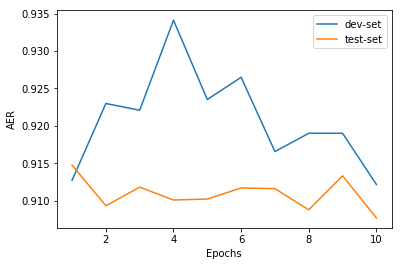

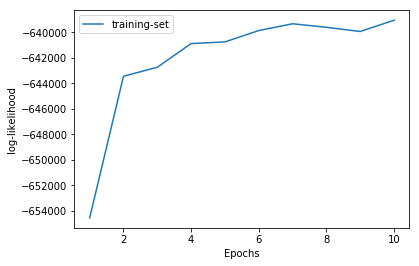

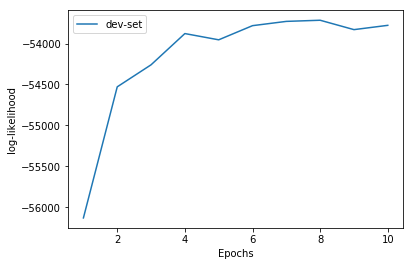

In [6]:
# plotting
import matplotlib.pyplot as plt

handles = []
ax1 = plt.plot(range(1, len(dev_AERs)+1), dev_AERs, label='dev-set')
handles.extend(ax1)
ax2 = plt.plot(range(1, len(test_AERs)+1), test_AERs, label='test-set')
handles.extend(ax2)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('AER')
plt.show()
plt.clf()

handles = []
ax1 = plt.plot(range(1, len(train_likelihoods)+1), train_likelihoods, label='training-set')
handles.extend(ax1)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('log-likelihood')
plt.show()
plt.clf()

handles = []
ax1 = plt.plot(range(1, len(dev_likelihoods)+1), dev_likelihoods, label='dev-set')
handles.extend(ax1)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('log-likelihood')
plt.show()
plt.clf()

# Gate

In [8]:
tf.reset_default_graph()

with tf.Session() as sess:

    # some hyper-parameters
    # tweak them as you wish
    batch_size=16  # on CPU, use something much smaller e.g. 1-16
    max_length=10
    lr = 0.001
    lr_decay = 0.0  # set to 0.0 when using Adam optimizer (default)
    emb_dim = 64
    mlp_dim = 128

    # our model
    # change context to : "gate", "concat", or "col_discrete". "col_discrete is for T3"
    model = NeuralIBM1Model(
        x_vocabulary=vocabulary_e, y_vocabulary=vocabulary_f, 
        batch_size=batch_size, emb_dim=emb_dim, mlp_dim=mlp_dim, session=sess, context="gate")

    # our trainer
    trainer = NeuralIBM1Trainer(
        model, train_e_path, train_f_path, 
        dev_e_path, dev_f_path, dev_wa,
        test_e_path, test_f_path, test_wa,
        num_epochs=10, batch_size=batch_size, 
        max_length=max_length, lr=lr, lr_decay=lr_decay, session=sess)

    # now first TF needs to initialize all the variables
    print("Initializing variables..")
    sess.run(tf.global_variables_initializer())

    # now we can start training!
    print("Training started..")
    results = trainer.train()
    dev_AERs, test_AERs, train_likelihoods, dev_likelihoods = results

Training with B=16 max_length=10 lr=0.001 lr_decay=0.0
Initializing variables..
Training started..
Shuffling training data
Iter   100 loss 23.554701 accuracy 0.18 lr 0.001000
Iter   200 loss 17.711666 accuracy 0.16 lr 0.001000
Iter   300 loss 24.308781 accuracy 0.22 lr 0.001000
Iter   400 loss 23.934555 accuracy 0.18 lr 0.001000
Iter   500 loss 16.520836 accuracy 0.28 lr 0.001000
Iter   600 loss 14.746223 accuracy 0.27 lr 0.001000
Iter   700 loss 8.333223 accuracy 0.43 lr 0.001000
Iter   800 loss 14.508146 accuracy 0.24 lr 0.001000
Iter   900 loss 15.392241 accuracy 0.26 lr 0.001000
Iter  1000 loss 18.249819 accuracy 0.27 lr 0.001000
Iter  1100 loss 12.826303 accuracy 0.34 lr 0.001000
Iter  1200 loss 12.925019 accuracy 0.34 lr 0.001000
Iter  1300 loss 16.499754 accuracy 0.24 lr 0.001000
Iter  1400 loss 15.047911 accuracy 0.29 lr 0.001000
Iter  1500 loss 11.852985 accuracy 0.30 lr 0.001000
Iter  1600 loss 11.528851 accuracy 0.35 lr 0.001000
Iter  1700 loss 10.327651 accuracy 0.29 lr 0.0

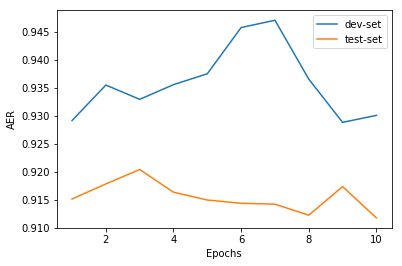

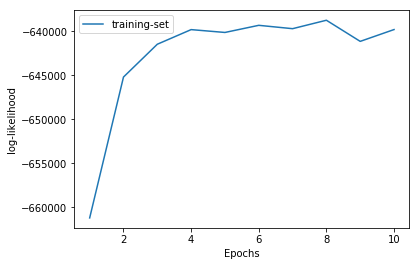

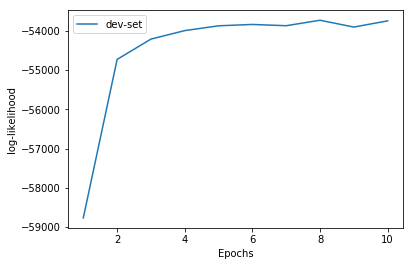

In [9]:
# plotting
import matplotlib.pyplot as plt

handles = []
ax1 = plt.plot(range(1, len(dev_AERs)+1), dev_AERs, label='dev-set')
handles.extend(ax1)
ax2 = plt.plot(range(1, len(test_AERs)+1), test_AERs, label='test-set')
handles.extend(ax2)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('AER')
plt.show()
plt.clf()

handles = []
ax1 = plt.plot(range(1, len(train_likelihoods)+1), train_likelihoods, label='training-set')
handles.extend(ax1)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('log-likelihood')
plt.show()
plt.clf()

handles = []
ax1 = plt.plot(range(1, len(dev_likelihoods)+1), dev_likelihoods, label='dev-set')
handles.extend(ax1)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('log-likelihood')
plt.show()
plt.clf()